<a href="https://colab.research.google.com/github/stefdepr/deep_learning/blob/main/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multivariate time series: training and analysis

This notebook provides example code you can use for training and analysing your models. Note that **it is not advised** to run and train all models for this assignment in a single notebook. Ideally, in order not to loose your way in your own notebooks, you make **at least** a separate notebook for each type of model in this assignment, selecting only the code you need for that model.

You can get additional inspiration from the "Time series forecasting" demo notebook from the Tensorflow docs:

https://www.tensorflow.org/tutorials/structured_data/time_series

This notebook heavily uses tensorflow utilities we haven't seen in class yet and is sometimes less easy to follow. We use some of the helper functions from that notebook in the code below.

## Imports and Drive mounting


In [ ]:
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn as sk
import pandas as pd
from pandas import read_csv
from datetime import datetime
import math
import os

# fix random seed for reproducibility
seed = 2022
np.random.seed(seed)  


In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.losses import MAE


2.8.0


## Assignment overview

The text below is de same as the text at the end of the preprocessing notebook. 

**However, one important piece of information was missing: we will use MAE (mean absolute error) to evaluate our models.**

In your last graded assignment, you will build a model to predict pollution in a big city on past pollution info as well as past wheather info. You receive a multi-variate time series data set which contains hourly data. 
**Your task is to predict pollution 4 hours ahead** in order to be able to build a citizen warning system. The error measure you need to minimise is Mean Absolute Error. As described in the preprocessing notebook, you will **use the pollution samples from the last year for testing** and **from the one-but-last year for validation**. 

We already provide the simplest time series prediction baseline: using the current pollution value as a prediction.

Your assignment consists of three steps (please also check the instructions in the slides):

1) First make the following baseline model: a network that only predicts pollution based on the **current values of all input time series (pollution and wheather)** to predict for 4 hours ahead, i.e. a purely feature based dense model that does not take history into account. You can also use this  model to do an initial investigation of the importance of each feature! 
This baseline should at least outperform the simplest baseline.

2) Second, you explore time series models to predict pollution (4 hours ahead, using only **current pollution and pollution history**, so a single timeseries. Here, you build **both, a window-based and a GRU network**. 

**Important to note here:** both types of models use a time window of data as inputs. The window size is an important hyperparameter to explore here. However, the window size plays a different role and has a different impact in each model type!! Make sure you understand their impact from the theory lecture before starting your exploration.
Again, all models should at least outperform the simplest baseline.

3) Now use all available information to build one or multiple good time series models that uses current values and histories of multiple features. It may be beneficial to shuffle the features first (using a linear of non-linear dense layer) before feeding them into a time series model.  


## Analysis

Since this is a regression task, there are no misclassifications: the analysis should focus on visualising the predictions on train and validate or test sets. Code for this is suggested in the training notebook. Please make sure to not only make the necessary plots, but also to discuss them. Also provide an overview table of train, validate and test errors for teh models of each stage and a comparative discussion of model properties and performance.



## Timing

**This assignment is quite extensive because you have to try out more different things.** try to maximally use the experience you already gained to efficiently tune the networks. Also, the aim of this assignment is **to explore and compare several approaches to time series prediction**, not to try and get the very best scoring models. Once you find a network that is properly tuned, do not waste time on trying to get that extra small improvement. Try to focus on exploring and understanding which effect (if any) the different options have and link this back to theory about each model type and/or the properties of this data set. 

If you have time left after finishing all the tasks, you can still revisit your best model(s) to try and improve! However, be aware of the fact that this task will never be perfectly solvable, because you simply do not have enough information to perfectly predict pollution.

The deadline for this assignment is **Friday, March 25, 23:30**. 
For a good planning, aim at finishing  part 1 and making good progress on part 2 before the support session of Monday, March 21st! That way, you can use the hands-on support session to ask us whether you are on the right track.


In [ ]:
# uncomment if you want to use Drive

from google.colab import drive
drive.mount('/content/gdrive')
#

##!ls '/content/gdrive/My Drive/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Loading the data

The code below reads the train and test datasets that were generated by the preprocessing notebooks. Obviously: feel free to create your own feature sets, and to change the filenames and paths as you need.

Throughout this notebook, statements relating to the test set are put in comments, since you do not have the test data yet when the assignment starts.


In [ ]:
# load data

# like in the previous assignments, you will need 4 datasets overall:
# train, validate, train_all (train+validate), and test


# The PATH setting below assumes you just uploaded the data file to your Colab session
# When using Drive: replace this by the path where you put the data file

# since you don't have the test data yet, statements related to that are in comment for now

DATAPATH = '/content/gdrive/My Drive/Colab Notebooks/assignment 3/'  
TRAINDATAFILE = DATAPATH+'preprocessed_train_data.csv'
VALDATAFILE = DATAPATH+'preprocessed_val_data.csv'

TRAINVALDATAFILE = DATAPATH+'preprocessed_train_val_data.csv'
TESTDATAFILE = '/content/gdrive/MyDrive/Colab Notebooks/assignment 3/pollution_data_test.csv'

train_dataset = read_csv(TRAINDATAFILE, header=0, index_col=0)
val_dataset = read_csv(VALDATAFILE, header=0, index_col=0)

train_all_dataset = read_csv(TRAINVALDATAFILE, header=0, index_col=0)
test_dataset = read_csv(TESTDATAFILE, header=0, index_col=0)

print(train_dataset.shape)
print(val_dataset.shape)
#print(train_all_dataset.shape)
#print(test_dataset.shape)

logbook_dir = '/content/gdrive/MyDrive/Colab Notebooks/assignment 3/logbook.txt'



(26280, 20)
(8760, 20)


In [ ]:
def plot_history(history):
  plt.figure(figsize = (6,4))
  
  plt.xlabel('Epoch')
  plt.ylabel('Mae')
  plt.plot(history.epoch, np.array(history.history['mae']),'g-',
           label='Train MAE')
  plt.plot(history.epoch, np.array(history.history['val_mae']),'r-',
           label = 'Validation MAE')
  plt.legend()
  plt.show()

In [ ]:
def PlotResults(labels,predictions,binsize = 10):
  num_samples = len(labels)
  
  fig = plt.figure(figsize=(16,16))
  spec = gridspec.GridSpec(ncols=4, nrows=4, figure=fig)
  ax1 = fig.add_subplot(spec[0, :])
  ax2 = fig.add_subplot(spec[1, :])
  ax3 = fig.add_subplot(spec[2:,0:2])
  ax4 = fig.add_subplot(spec[2:,2:])
  
  ax1.plot(labels,'k-',label='Labels')
  ax1.plot(predictions,'r-',label='Predictions')
  ax1.set_ylabel('Pollution')
  ax1.legend()
  
  errors=np.absolute(labels-predictions)
  ax2.plot(errors,'k-')
  ax2.set_ylabel("Absolute error")
  
  ax3.scatter(labels,predictions)
  ax3.set_xlabel('Labels')
  ax3.set_ylabel('Predictions')

  bins = np.arange(0,(np.ceil(np.max(errors)/binsize)+1)*binsize,binsize)
  
  ax4.hist(errors,bins=bins)
  ax4.set_xlabel('Absolute error')
  ax4.set_ylabel('Frequency')

  plt.show()

The files you just loaded contain all the features you generated. As mentioned in the instructions, subset selection is an important weapon against overfitting. Using the functions below, you can extract the features you need.

## Extracting and normalising the features

The files you have read in are pandas dataframes, containing a wide range of possibly useful features as well as the pollution values. In the first stage of this assignment, you will need to analyse the data and explore which features are most promising to use for predicting. In this section, we walk you through the following steps:

1. Extract the features you want to use
2. Train and apply a scaler to the feature matrices

We start by extracting the features.

In [ ]:
# extract data from dataframes, selecting the features you want
# the labels simply contain the pollution data 

# First, you need to select which features you want to use:

def feature_matrix(df,features):
    numsamples = df.shape[0]
    numfeatures = len(features)
    
    fm = np.zeros((numsamples,numfeatures))
    for idx in range(numfeatures):
        fm[:,idx] = df[features[idx]]
    return fm

# select the features you will use in your model here
# THE CODE BELOW IS ONLY AN EXAMPLE: you need to make your own selection!!

features = ['pollution','hour','month','temp','rain','snow','day_of_week',]


# Important: Tensorflow 2.x gives an error if you omit
# the np.asarray(...,,dtype=np.float32)

# train and validate
train_values = np.asarray(feature_matrix(train_dataset,features),dtype=np.float32)
train_labels = np.asarray(train_dataset['pollution'],dtype=np.float32)

val_values = np.asarray(feature_matrix(val_dataset,features),dtype=np.float32)
val_labels = np.asarray(val_dataset['pollution'],dtype=np.float32)

# data for retraining before testing
train_all_values = np.asarray(feature_matrix(train_all_dataset,features),dtype=np.float32)
train_all_labels = np.asarray(train_all_dataset['pollution'],dtype=np.float32)

# test data
test_values = np.asarray(feature_matrix(test_dataset,features),dtype=np.float32)
test_labels = np.asarray(test_dataset['pollution'],dtype=np.float32)



# check
print(train_values.shape)
print(train_labels.shape)

print(val_values.shape)
print(val_labels.shape)

#print(train_all_values.shape)
#print(train_all_labels.shape)

#print(test_values.shape)
#print(test_labels.shape)



(26280, 7)
(26280,)
(8760, 7)
(8760,)


We now have the selected features and the pollution in separate arrays. 
As you know by now, it is important to normalise the features. For each model, the parameters for rescaling and shifting (incorporated as trainable parameters in sklearn's scalers) need to be determined on the training set for that model. 

The flow for this is the following:

- initialise normaliser 1
- fit on training date
- use it to transform train and validation data

For your final model(s) and testing, you will also need a second normaliser:
- initialise normaliser 2
- fit on training+validation data
- use it to transform training+validation and test data

This has to be done **before** reformatting the data into windows (next section).  

Although we already did this before, the code below gives an example, The imports show that there are many different scalers. Especially with recurrent NNs, the choice of scaler can make a difference. Look up what each scaler does before choosing which one to try. Also, recurrent models may need different scalers than other models! Finally, you could also consider an alternative approach of starting your model with a batchnorm layer to let your model fine-tune the feature scaling.

In [ ]:
# imports to show that there are many different scalers
# especially with recurrent NNs, the choice of scaler can make a difference
# look up what they do before choosing which one to try

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

# Example: train standard scalers, apply to train and test data
# adapt to do all you need to do ...

SS1 = MinMaxScaler()
SS1.fit(train_values)

train_scaled = SS1.transform(train_values)
val_scaled = SS1.transform(val_values)

# train and apply scaler for test features - make sure to use the same type of scaler here!!

SS2 = MinMaxScaler()
SS2.fit(train_all_values)

train_all_scaled = SS2.transform(train_all_values)
test_scaled = SS2.transform(test_values)

## Transforming the data into the right format for model training

Wou now have rescaled feature matrices for all data sets, as well as the pollution values in a separate array. WHat remains to be done is align the model inputs with the corresponding labels. In this assignment, you will use models with two types of inputs: 
- a dense network that only uses the current input features for prediction
- window-based and sequential networks that use time windows for prediction

In this task, you need to predict the pollution value four hours into the future. This means that, even for the dense network (which used the current value for prediction), the first predicted pollution value (so the first label) will be the 5th pollution value in the time series. In a training sequence of, e.g., 1000 samples, this leaves at most 1000-4 samples for training. The same reasonig can be applied to validation and test sets.

When using a window of k>1 values (i.e., the current value and k-1 history values), the first label will be the k+4th value in the time series, leaving at most 1000-4-(k-1) samples for training. This means that, if we always use the maximal number of samples for training, validation and testing, this number depends on the window size, which is a model hyperparameter. Since we need to be able to evaluate and compare our models fairly, i.e.,  **using exactly the same validation and test sets** this is **not desirable**! 

In order to avoid this, we have determined a **maximal window size** of 2 weeks (336 hours) for this assignment. In each data set, the first label is set to be the 336+4th pollution sample, resulting in train, validate and test sets of fixed length. The actual window size (at least 1 and at most 336) is still a hyperparameter for you to optimise. 

The function below cuts out the samples from the data set for the window-based and recurrent sequential data models. For training a dense neural network baseline (using only the current features values): use a window size of 1 and then apply the numpy function np.squeeze() to remove the redundant middle dimension.

In [ ]:
# window-based and recurrent networks:

def create_dataset_windowed(features, labels, ahead=4, window_size=1, max_window_size=336):
    samples = features.shape[0]-ahead-(max_window_size-1) 
    window_size = min(max(window_size,1),max_window_size)
    
    dataX = []
    for i in range(samples):
        a = features[(i+max_window_size-window_size):(i+max_window_size), :]
        dataX.append(a)
    return np.array(dataX), labels[ahead+max_window_size-1:]

# set chosen window size
WINDOW = 16
X_train_w,r_train_w = create_dataset_windowed(train_scaled,train_labels, window_size=WINDOW)
X_val_w,r_val_w = create_dataset_windowed(val_scaled,val_labels, window_size=WINDOW)
X_train_all_w,r_train_all_w = create_dataset_windowed(train_all_scaled,train_all_labels, window_size=WINDOW)
X_test_w,r_test_w = create_dataset_windowed(test_scaled,test_labels, window_size=WINDOW)


print(X_train_w.shape)
print(r_train_w.shape)

# For training a dense network in stage 1, predicting the pollution only on the current feature values
# you need to set the window size to 1
# The resulting tensor then still has 3 dimensions (with the middle one = 1), 
# while tensorflow will expect a 2D tensor
# to obtain this: use the function np.squeeze (this removes any dimension of size 1)

#print(np.squeeze(X_train_w).shape)



(25941, 16, 7)
(25941,)


When tuning your convolutional model, try to think about the receptive fields of the features you extract (cf. lecture). The current network only has two layers of 2x2 filters, so the receptive fields are very small!!

The final model type is a recurrent model, which is demonstrated in the code below. Remember that LSTMs and GRUs require the input data to be scaled between 0 and 1!! Since currently, a standardscaler was used, the code below does not give useful results.

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_20 (GRU)                (None, 16, 32)            3936      
                                                                 
 gru_21 (GRU)                (None, 32)                6336      
                                                                 
 dense_20 (Dense)            (None, 10)                330       
                                                                 
 dense_21 (Dense)            (None, 1)                 11        
                                                                 
Total params: 10,613
Trainable params: 10,613
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
543/543 [==============================] - 30s 31ms/step - loss: 77.3446 - mae: 77.3446 - mse: 13396.5420 - val_loss: 67.4153 - val_mae: 67.4153 - val_mse: 10894.5049
Epo

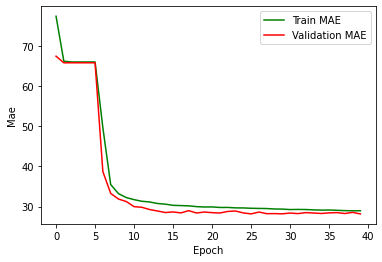

In [ ]:
from numpy.ma.core import tanh
from sklearn.metrics import mean_absolute_error
HIDDEN_RNN = 32


# regularisers - all set to zero for now
wreg = L1L2(l1=0.0, l2=0.000)
l1 = 0.0
l2 = 0.000

GRUmodel = Sequential()
dropout1 = 0
dropout2 = 0
dropout3 = 0.3

# Note that you can also make multi-layer GRUs 
# Since these send their output to another GRU, they should output whole sequences 
# instead of predictions
# For this reason, all but the last GRU layer should have return_sequences=True
window_sizes = [4,16,32,64,128,256]



GRUmodel.add(GRU(input_shape = (16,7), 
                   units=HIDDEN_RNN,
                   return_sequences=True, 
                   kernel_regularizer=wreg,dropout=dropout1))


GRUmodel.add(GRU(input_shape = (16,7), 
                   units=HIDDEN_RNN,
                   return_sequences=False, 
                   kernel_regularizer=wreg,dropout = dropout3))
GRUmodel.add(Dense(10,activation='relu')) # note that a different nonlinearity may be useful here
GRUmodel.add(Dense(1))
GRUmodel.summary()

GRUmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='mae', metrics=['mae','mse'])


batch_size=64
epochs=40
GRU_history = GRUmodel.fit(X_train_all_w, r_train_all_w, 
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_w, r_test_w),
          shuffle=True)
plot_history(GRU_history)

y_train_GRUmodel = GRUmodel.predict(X_train_all_w)
y_val_GRUmodel = GRUmodel.predict(X_test_w)

mae_train_GRUmodel = mean_absolute_error(r_train_all_w,y_train_GRUmodel)
mae_val_GRUmodel = mean_absolute_error(r_test_w,y_val_GRUmodel)

with open(logbook_dir, 'a') as writefile:
  writefile.write("\nThis is a GRU model:")
  writefile.write(f"\nwindow size: {WINDOW} hidden_rnn: {HIDDEN_RNN }")
  writefile.write(f"\nmae train: {mae_train_GRUmodel} mae val: {mae_val_GRUmodel} gru layers: 4 dense activation: relu dense neurons: 10 dropout first layer: {dropout1} dropout seond layer {dropout2} dropout seond layer {dropout3} l1: {l1} l2: {l2} \n")
  writefile.write(f"epochs {epochs} batch size {batch_size}\n")




"Current pollution" baseline:
 train mae =  27.62849 
 validation mae =  29.111084


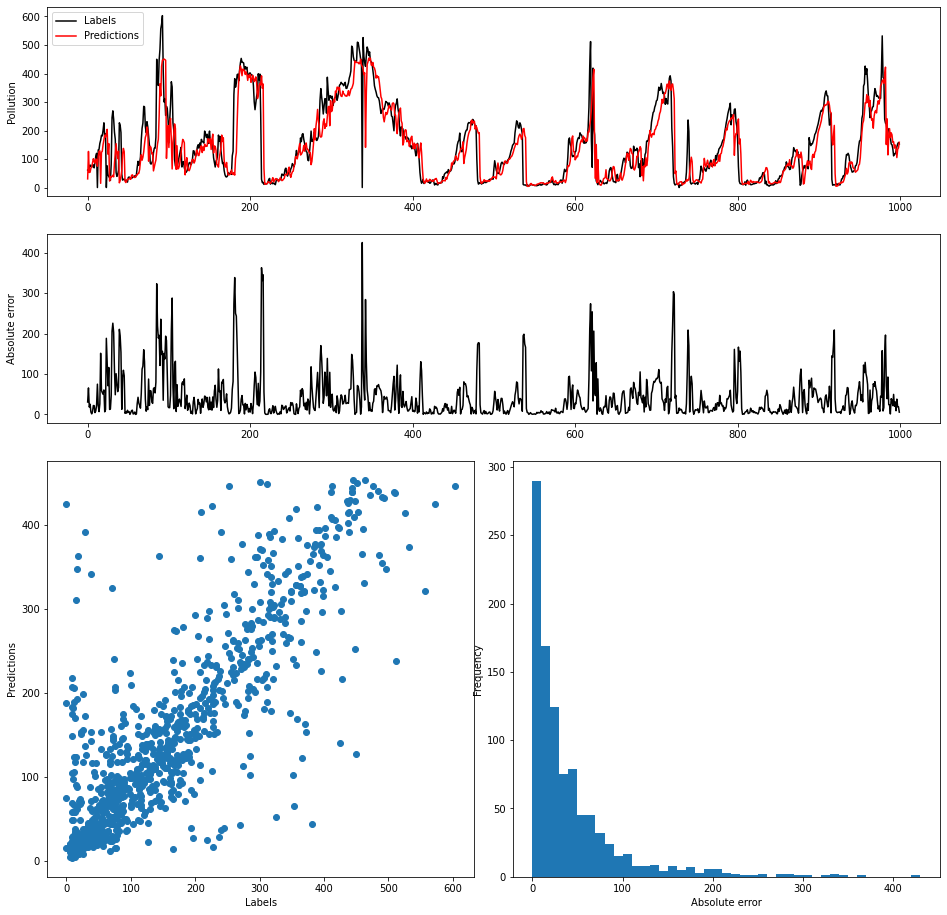

In [ ]:
from sklearn.metrics import mean_absolute_error

y_train_GRUmodel = GRUmodel.predict(X_train_w)
y_val_GRUmodel = GRUmodel.predict(X_val_w)

mae_train_GRUmodel = mean_absolute_error(r_train_w,y_train_GRUmodel)
mae_val_GRUmodel = mean_absolute_error(r_val_w,y_val_GRUmodel)

print("\"Current pollution\" baseline:\n train mae = ",mae_train_GRUmodel,
      "\n validation mae = ",mae_val_GRUmodel)

# Visualise first 1000 predictions for validation
PlotResults(r_val_w[:1000],y_val_GRUmodel[:1000,0])

Now it's up to you to try and improve these models and understand, for this particular problem, what would work and what wouldn't!